# Analysing Time Series Data using STUMPY (Matrix Profile)

This notebook contains examples for pulling time series data from Google Trends and using the STUMPY Python library to calculate the matrix profile.

References:
1. [Analyzing Google Trends with Matrix Profile](https://www.naut.ca/blog/2019/04/20/google-trends-and-matrix-profile/)
2. [Matrix Profile Homepage](https://www.cs.ucr.edu/~eamonn/MatrixProfile.html](https://www.cs.ucr.edu/~eamonn/MatrixProfile.html)
3. [STUMPY GitHub Page](https://github.com/TDAmeritrade/stumpy)

In [1]:
import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from pytrends.request import TrendReq

# Pull data from Google using pytrends

pytrends: https://github.com/GeneralMills/pytrends

Let's take a look at Google searches for UBC and SFU over the last 5 years.

In [2]:
pytrends = TrendReq(hl='en-US', tz=480) # Pacific time timezone offset = 480
pytrends.build_payload(['UBC', 'SFU'], cat=0, timeframe='today 5-y', geo='CA', gprop='')
df = pytrends.interest_over_time()

In [6]:
df.head(n=20)

,UBC,SFU,isPartial
date,,,
2014-06-22,50,24,False
2014-06-29,49,18,False
2014-07-06,46,24,False
2014-07-13,43,23,False
2014-07-20,42,27,False
2014-07-27,39,23,False
2014-08-03,39,21,False
2014-08-10,46,22,False
2014-08-17,47,19,False


Just by observing the plotted data, we seem to be seeing 2 spikes every year. A big one in September and a slightly smaller one in January. September is the start of the academic year, and it's also when online applications for prospective undergraduates open, which probably explains the bigger spike. The smaller spike in January could probably be explained by the start date for Term 2.

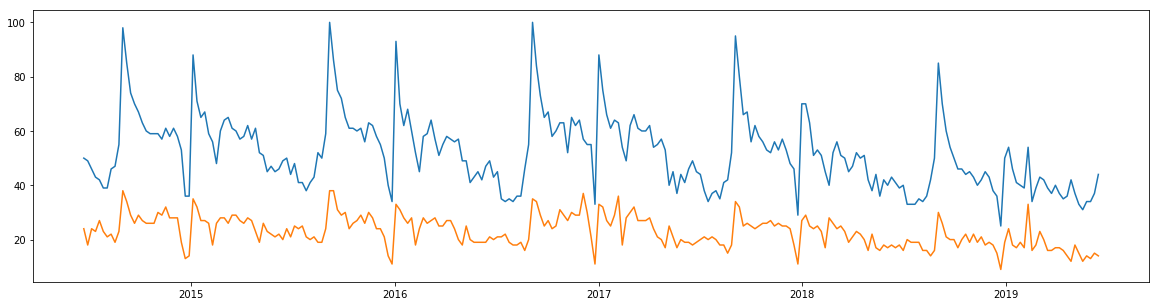

In [7]:
plt.figure(figsize=(20,5))
plt.plot(df.index,df['UBC'],df.index,df['SFU'])
plt.show()

# 1-Dimensional Data

Let's see if we can use the matrix profile to find anything else.

STUMPY wants the data as a float

In [8]:
data = df['UBC'].values.astype(float)

The only parameter for the matrix profile is the window size for the search. Let's try different numbers and look at how the profile changes. Green line at the top is the data, black lines are the matrix profiles with different window sizes.

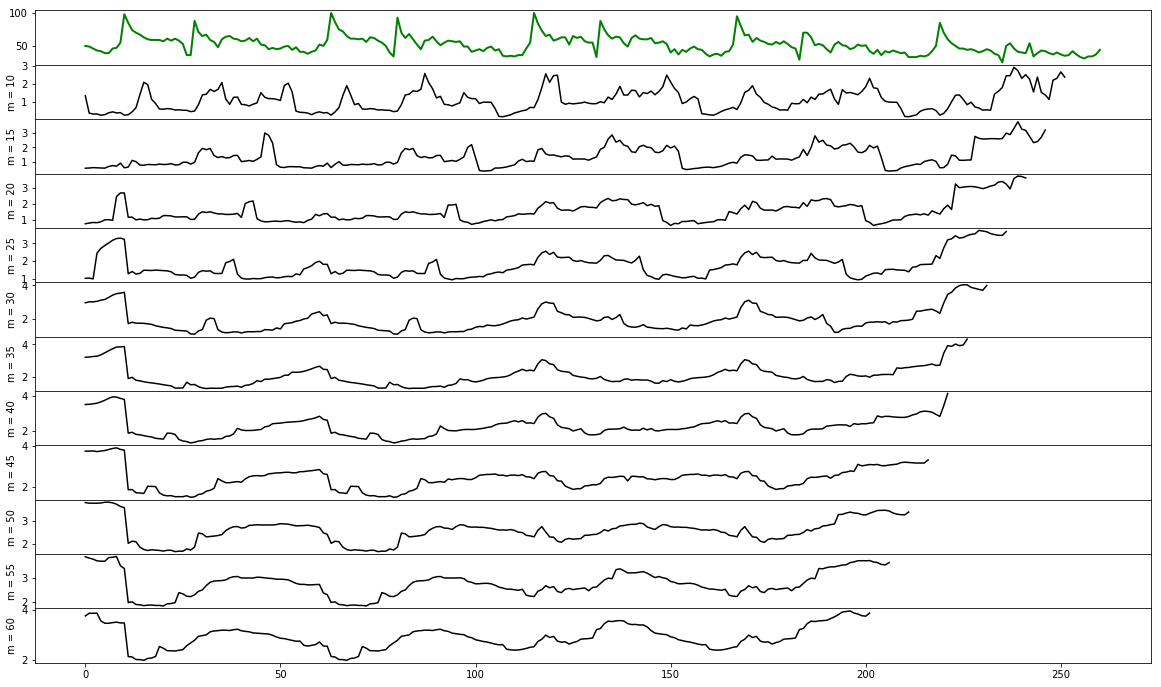

In [9]:
M = np.arange(10,65,5)
plt.figure(figsize=(20,12))

ax = plt.subplot(len(M)+1,1,1)
plt.plot(data, color='g', linewidth=2)

for i,m in enumerate(M):
    stump_results = stumpy.stump(data, m=m)
    out_df = pd.DataFrame(stump_results, columns=['mp', 'inx', 'left', 'right'])
    MP = [item[0] for item in stump_results]  # Extracting only the Matrix Profile values from the STUMP results
    ax2 = plt.subplot(len(M)+1,1,i+2,sharex=ax)
    ax2.set_ylabel('m = {0}'.format(m))
    plt.plot(MP, color='k')
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
plt.show()

### Select the window size that seems to make the most sense
I'm (arbitrarily) selecting 20 to take a closer look.

In [10]:
m=20 # 7 days * 4 weeks * months
stump_results = stumpy.stump(data, m=m)
out_df = pd.DataFrame(stump_results, columns=['mp', 'inx', 'left', 'right'])
MP = [item[0] for item in stump_results]

Using the matrix profile, we can also calculate the time series chains using `allc`.

In [11]:
S, C = stumpy.allc(out_df['left'].values, out_df['right'].values)
S.sort(key=len,reverse=True)

### Plot the time series chains

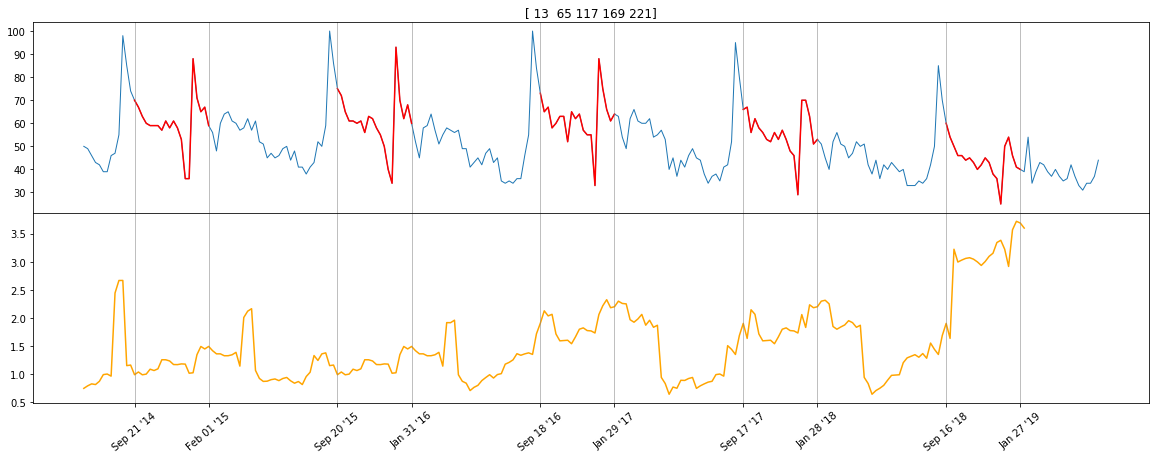

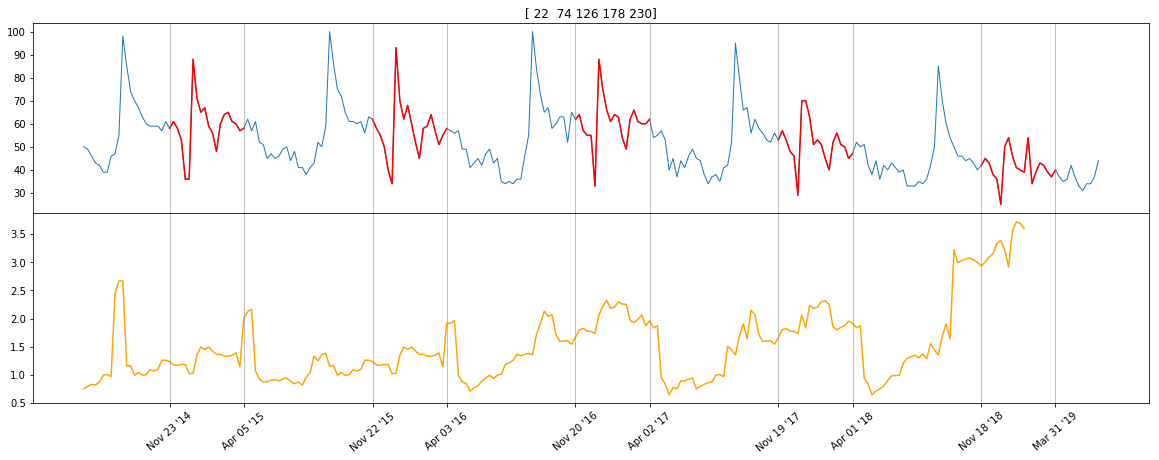

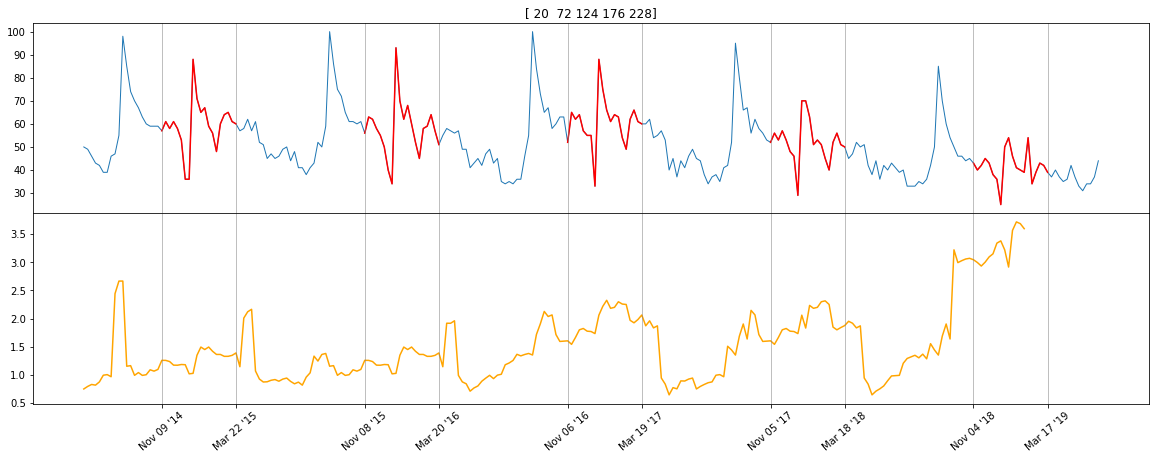

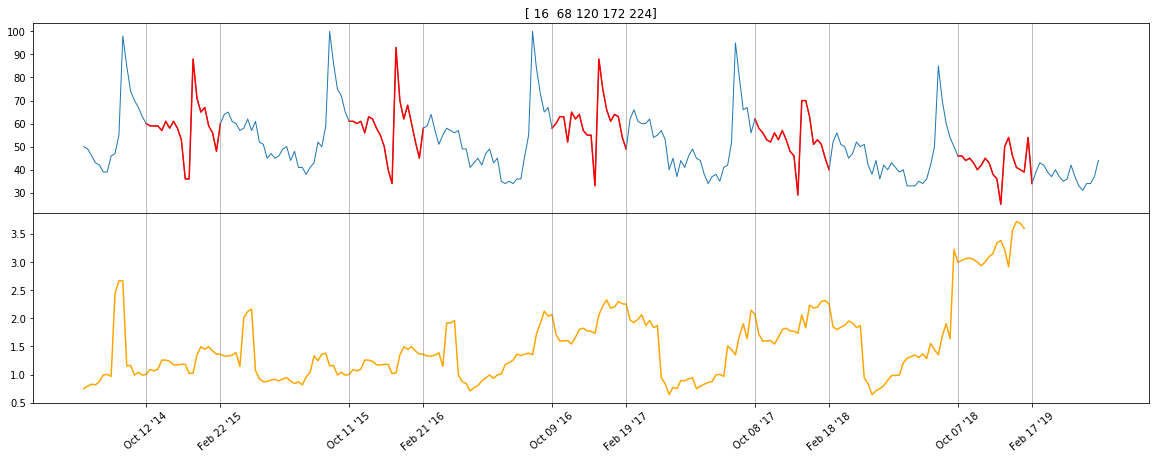

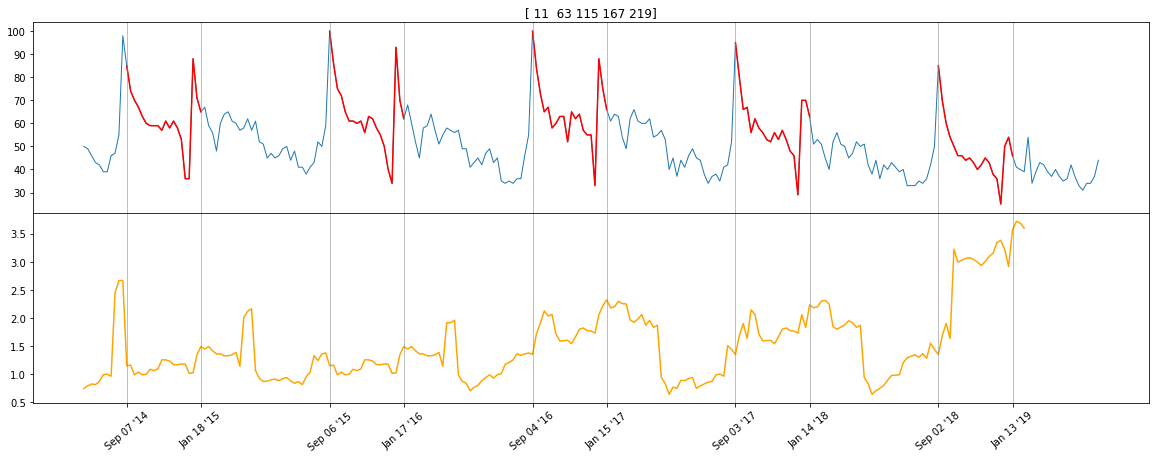

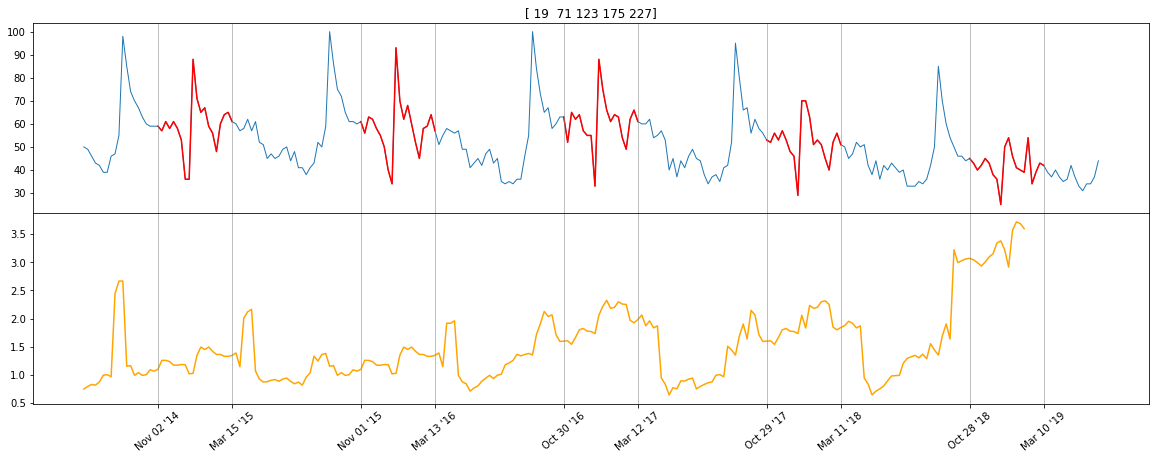

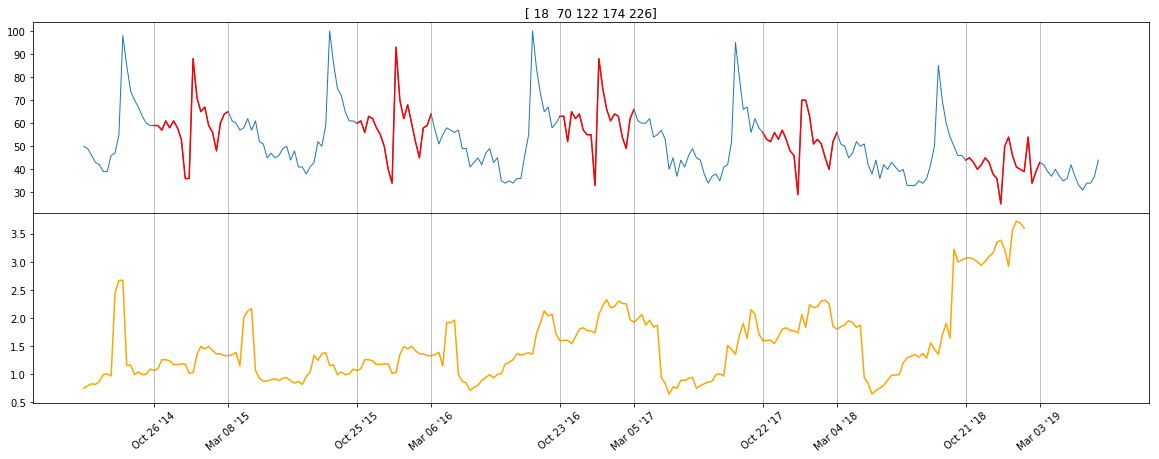

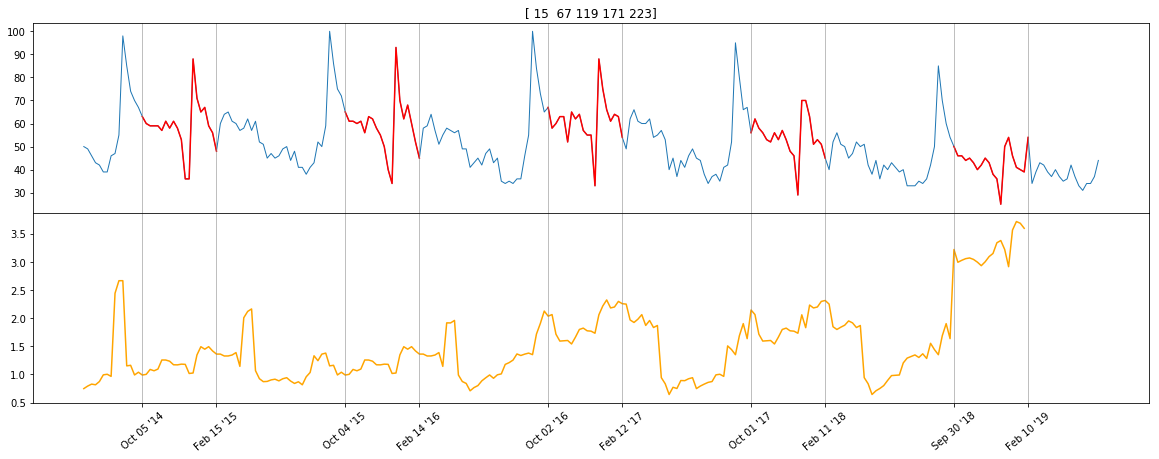

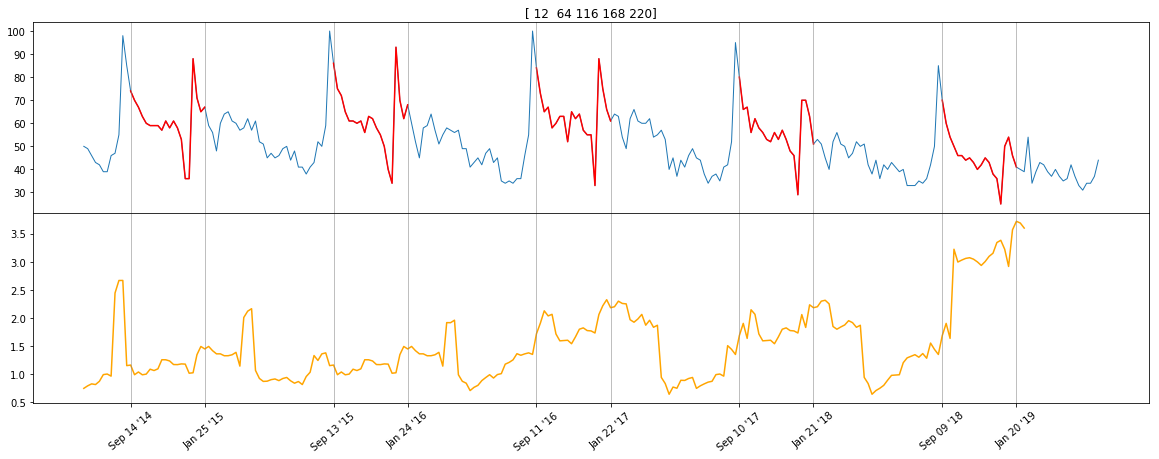

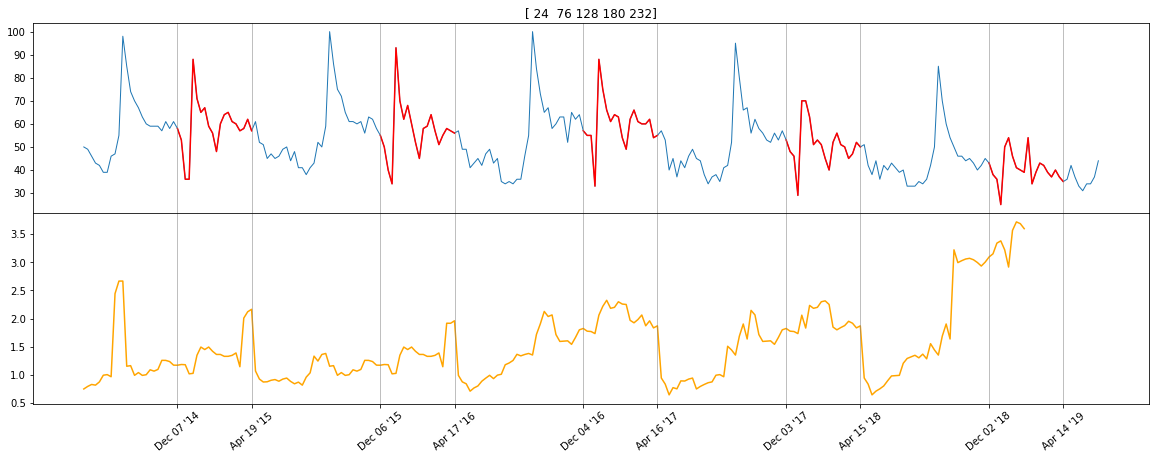

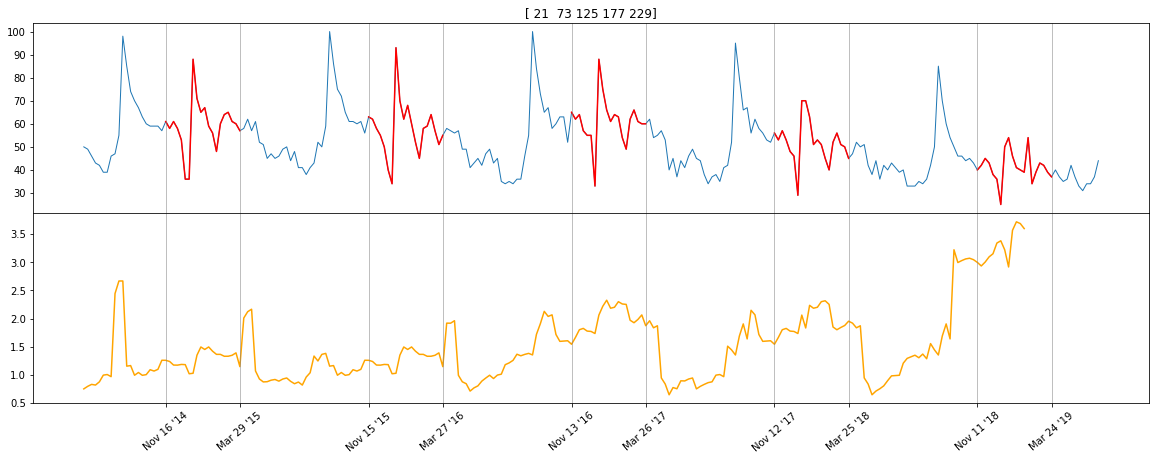

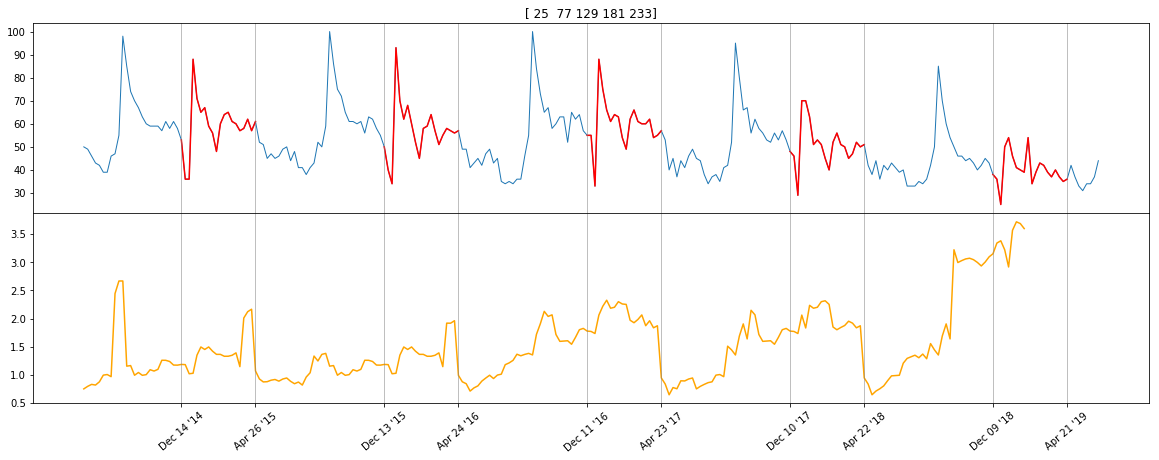

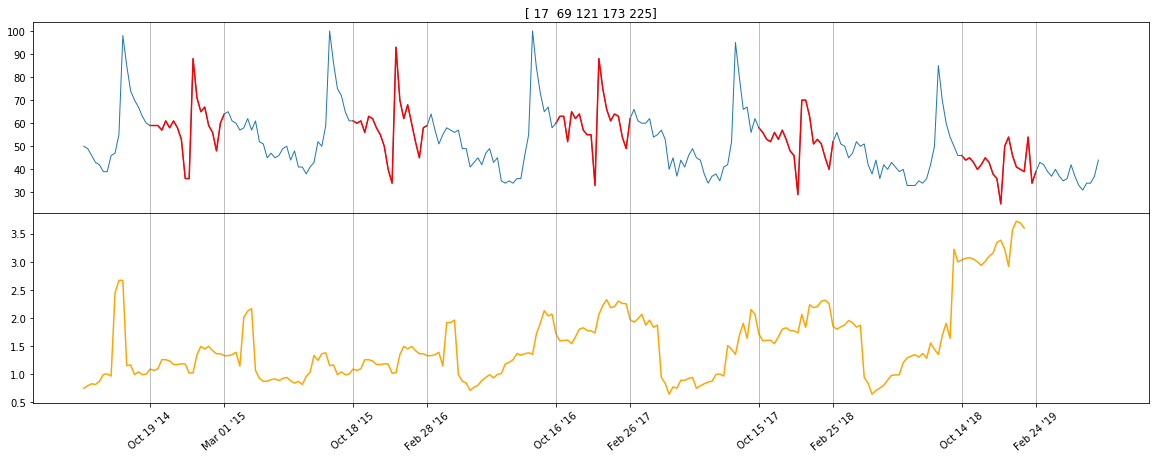

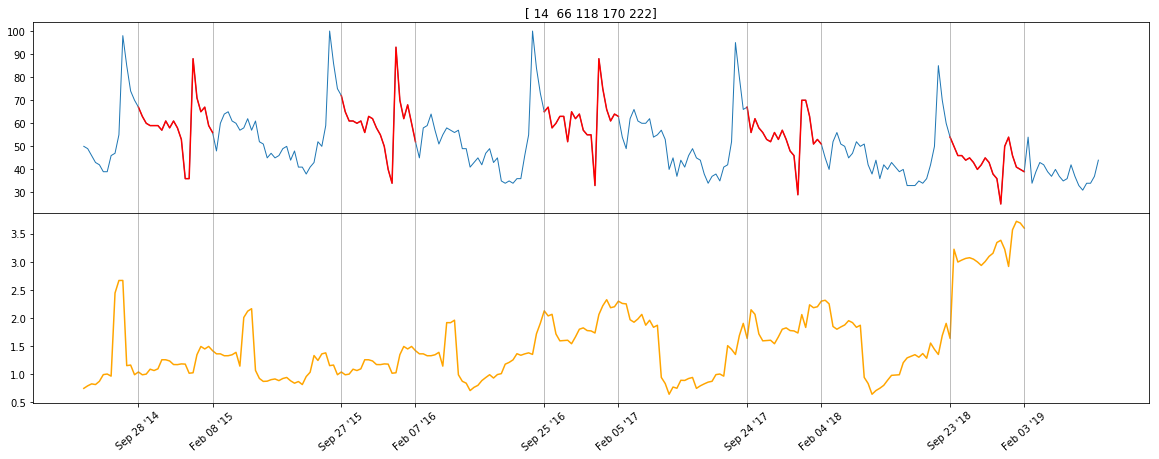

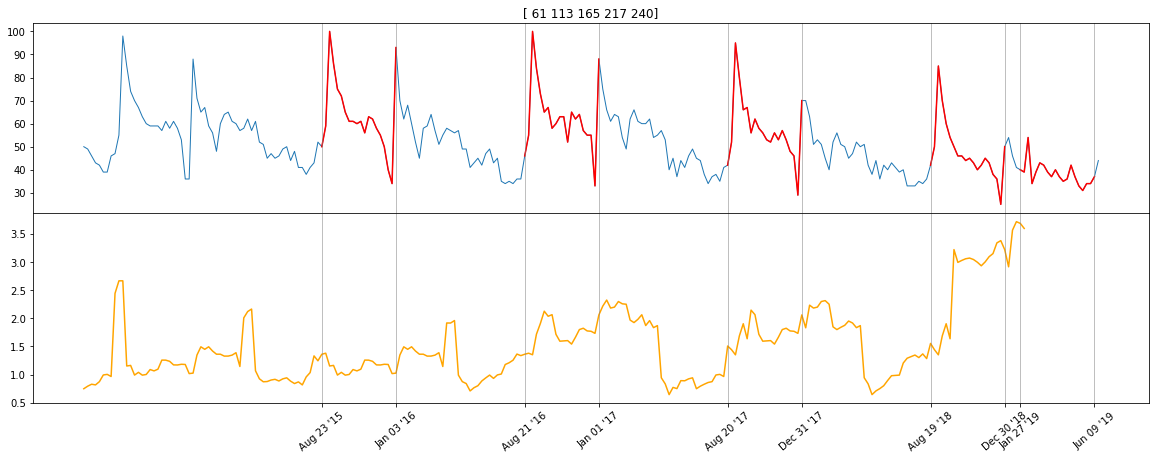

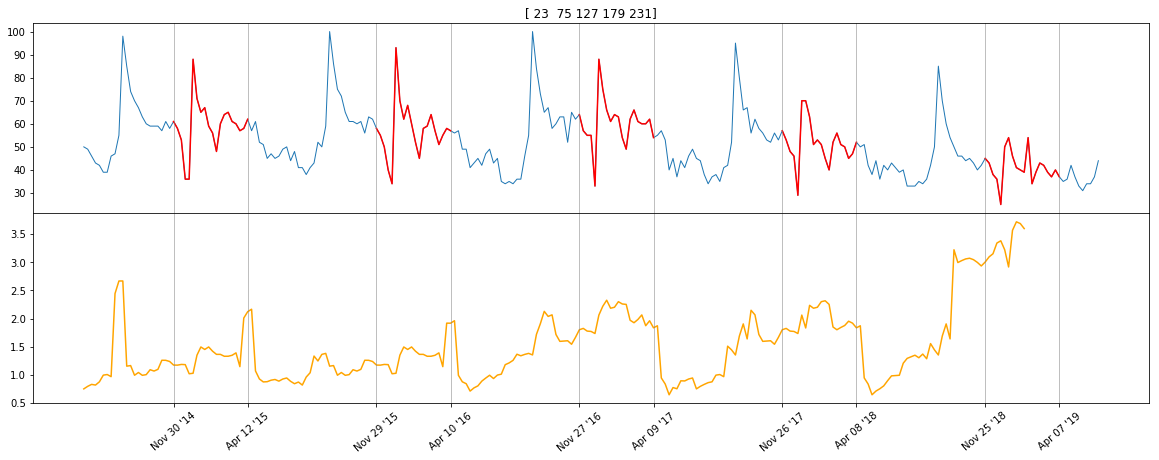

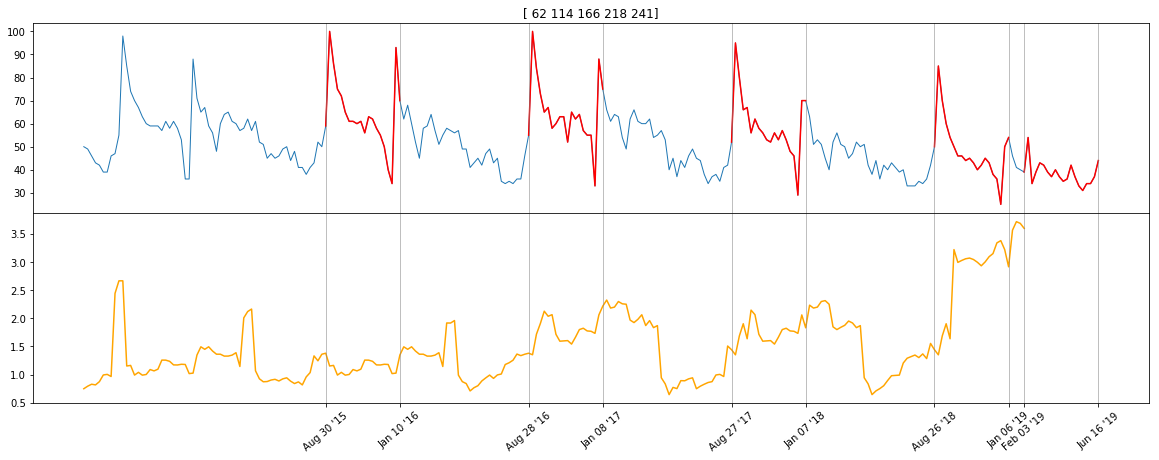

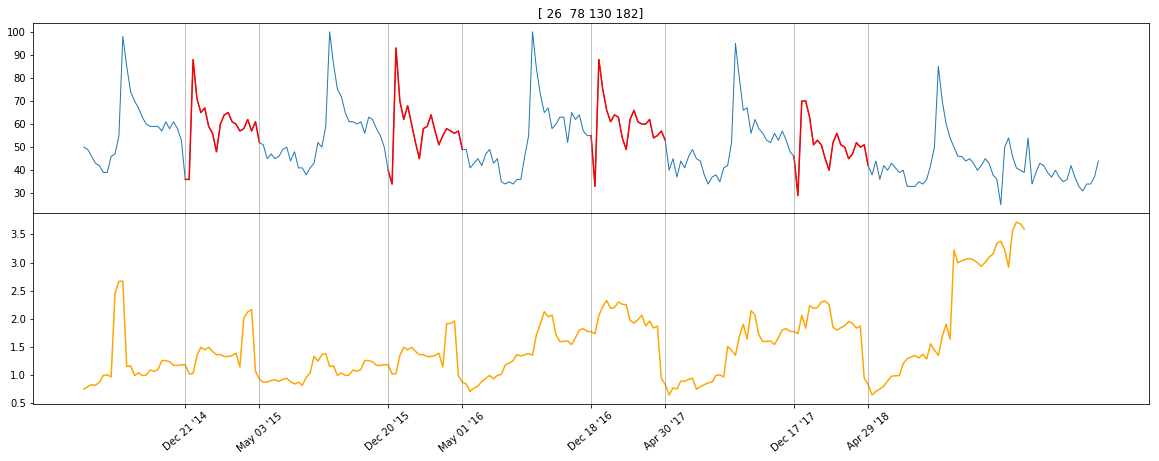

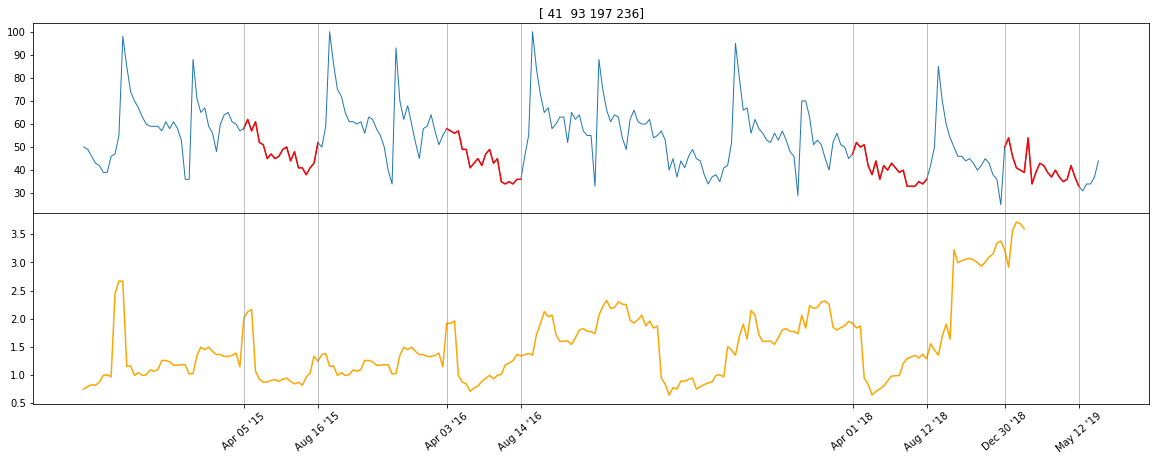

In [12]:
for s in S:
    if len(s)>3:
        plt.figure(figsize=(20,7))
        ax1=plt.subplot(211)
        plt.plot(data, linewidth=1)

        topn = s

        for n in topn:
            plt.plot(np.arange(n,n+m),data[n:n+m], color='r')
            plt.axvline(n, color='grey', linewidth=0.5)
            plt.axvline(n+m-1, color='grey', linewidth=0.5)

        plt.subplot(212, sharex=ax1)
        plt.plot(MP, color='orange')

        for n in topn:
            plt.axvline(n, color='grey', linewidth=0.5)
            plt.axvline(n+m-1, color='grey', linewidth=0.5)

        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
        tick_locs = np.append(topn,topn+m-1)
        plt.xticks(tick_locs, df.index.strftime('%b %d \'%y').values[tick_locs], rotation=40)
        ax1.set_title(s)
        plt.show()        

# Multidmensional Data

In [13]:
data = df[['UBC','SFU']].values.T.astype(float)

Run the mstamp algorithm on 2 time series instead of just 1.

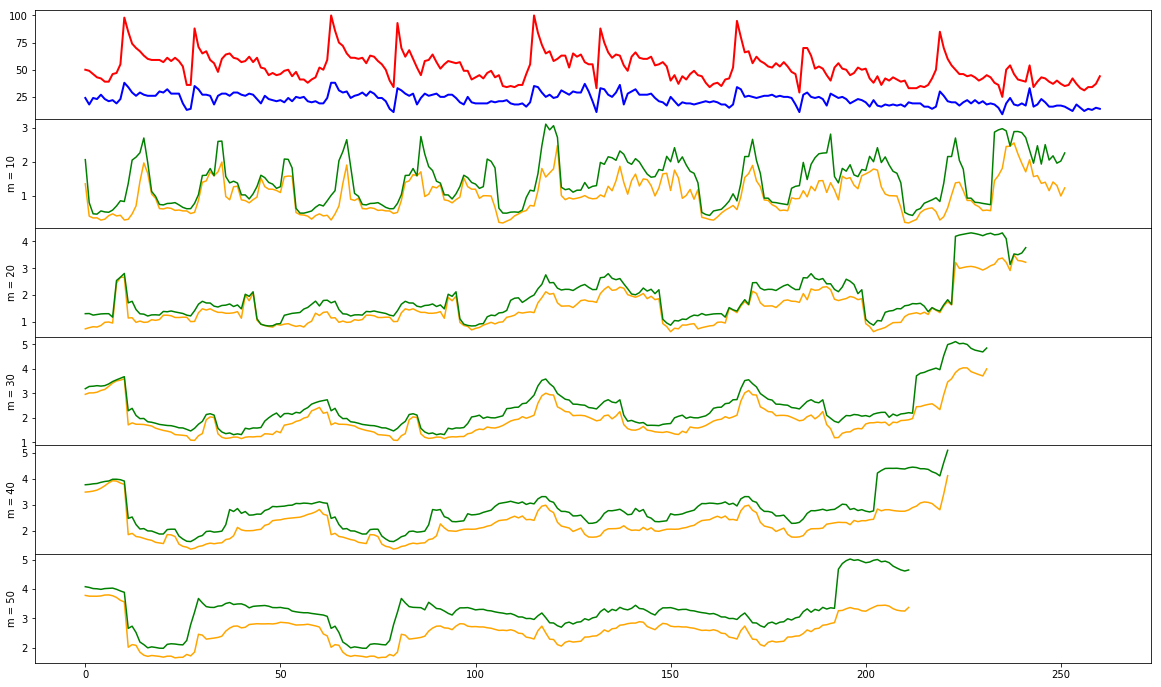

In [14]:
M = [10,20,30,40,50]
plt.figure(figsize=(20,12))

ax = plt.subplot(len(M)+1,1,1)
plt.plot(data[0], color='r', linewidth=2)
plt.plot(data[1], color='b', linewidth=2)

for i,m in enumerate(M):
    matrix_profile, mp_indices = stumpy.mstump(data, m=m)
    out_df = pd.DataFrame(matrix_profile)
    MP1 = matrix_profile[0]
    MP2 = matrix_profile[1]
    ax2 = plt.subplot(len(M)+1,1,i+2,sharex=ax)
    ax2.set_ylabel('m = {0}'.format(m))
    plt.plot(MP1, color='orange')
    plt.plot(MP2, color='g')
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
plt.show()